In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import sparse
from ProtoRegNet import ProtoRegNet, SaveProtoRegNetVars
from sklearn.datasets import make_moons
from prototype_utils import MLPClassifier
from skorch_utils import EarlyStopping, NaNStopping, MLP
from skorch.callbacks import LRScheduler

from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint, reciprocal
random_state=0


# Testing LDMNet on toy data

To verify the implementation of LDMNet, this notebook includes some experiments with toy data.

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import torch

from scipy import sparse
from LDMM import LDMNetSkorch, SaveLDMNetVars
%run LDMM_plot_utils.py
from sklearn.datasets import make_moons
from prototype_utils import MLPClassifier
from skorch_utils import (EarlyStopping, NaNStopping, MLP, NNClassifier, 
                          SaveWeights, LRScheduler, learning_curve)
from skorch.utils import to_numpy

from scipy.stats import uniform, reciprocal
from sklearn.model_selection import RandomizedSearchCV, StratifiedShuffleSplit
from sklearn.decomposition import PCA

import pandas as pd

random_state=0
plt.rcParams['image.cmap'] = 'RdBu'

## Generating data: S curve (2D surface on 3D coords)
Toy data for this experiments is an S shaped surface generated by `sklearn`'s function `make_s_curve`.
Each point is returned with a continuous value as label, which is quantized in two discrete values to generate a binary classification problem. Continuous values will be kept only for visualization purposes.

We generate 100 points with no noise. Bellow, 3D plots of the surface and a 2D plot made via PCA dimensionality reduction.


In [3]:
from sklearn.datasets import make_s_curve
n_samples=500
X, y = make_s_curve(n_samples=n_samples, noise=0, random_state=random_state)
y_orig = y
N = 5
# for more than 2 clases
hist, bin_edges = np.histogram(y, bins=N)
y = np.digitize(y, bin_edges[:-1])-1
X = X.astype(np.float32)
y = y.astype(np.int64)

Text(0.5,1,'PCA on S - variance ratio: 0.7 0.2 0.1')

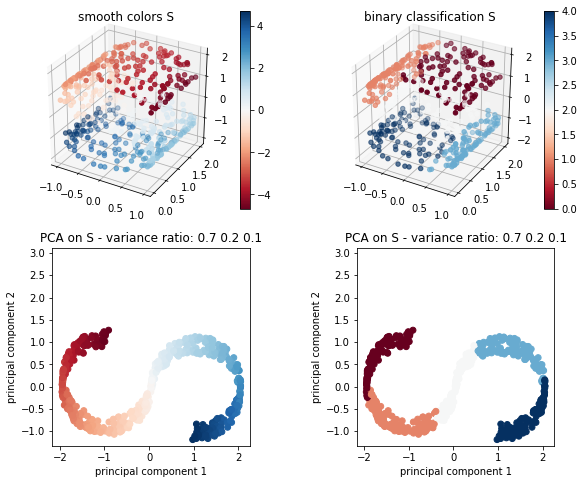

In [4]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(221, projection='3d')
plt.title('smooth colors S')
p = ax.scatter(*X.T, c=y_orig)
plt.colorbar(p)
ax = fig.add_subplot(222, projection='3d')
plt.title('binary classification S')
p = ax.scatter(*X.T, c=y)
plt.colorbar(p)
proj = PCA(n_components=3, random_state=random_state)
X2d = proj.fit_transform(X)
plt.subplot(2,2, 3)
plt.scatter(*X2d[:,0:2].T, c=y_orig)
plt.xlabel('principal component 1')
plt.ylabel('principal component 2')
plt.axis('square')
plt.title("PCA on S - variance ratio: %0.1f %0.1f %0.1f" % tuple(proj.explained_variance_ratio_[0:3]))
plt.subplot(2,2, 4)
plt.scatter(*X2d[:,0:2].T, c=y)
plt.xlabel('principal component 1')
plt.ylabel('principal component 2')
plt.axis('square')
plt.title("PCA on S - variance ratio: %0.1f %0.1f %0.1f" % tuple(proj.explained_variance_ratio_[0:3]))

({'algorithm': 'auto',
  'eps': 0.2,
  'leaf_size': 10,
  'metric': 'euclidean',
  'metric_params': None,
  'min_samples': 5,
  'n_jobs': -1,
  'p': None},
 194)

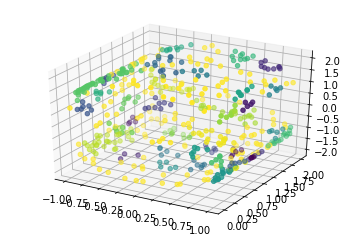

In [5]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

cluster = DBSCAN(eps=0.2,
                 min_samples=5,
                 leaf_size=10,
                 n_jobs=-1)
cluster.fit(X)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*X.T, c=cluster.labels_, cmap='viridis_r')
cluster.get_params(), cluster.components_.shape[0]

### Sanity check: Simple neural net
Checking how an 8 neuron 1 hidden layer MLP solves the problem. 20% of training data is held out as validation for deciding on early stopping neural network training.

In [6]:
torch.manual_seed(random_state)
torch.cuda.manual_seed(random_state)
module = MLP(X.shape[1], 8, N, drop_proba=0.5)
simple_model = NNClassifier(
    module=module,
    max_epochs=500,
    batch_size=X.shape[0],
    lr=0.01,
    device='cuda',
    verbose=1,
    callbacks=[EarlyStopping(10, 'valid_loss'),
               NaNStopping()]
)

In [7]:
_ = simple_model.fit(X, y)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.5647       0.0980        1.5366  0.0078
      2        1.5818       0.0980        1.5352  0.0057
      3        1.5733       0.0980        1.5338  0.0055
      4        1.5641       0.1078        1.5324  0.0060
      5        1.5620       0.1078        1.5310  0.0076
      6        1.5671       0.1176        1.5297  0.0072
      7        1.5772       0.1176        1.5282  0.0069
      8        1.5456       0.1176        1.5268  0.0070
      9        1.5623       0.1176        1.5254  0.0062
     10        1.5595       0.1176        1.5241  0.0077
     11        1.5521       0.1275        1.5228  0.0059
     12        1.5673       0.1471        1.5214  0.0067
     13        1.5606       0.1471        1.5201  0.0064
     14        1.5460       0.1471        1.5188  0.0066
     15        1.5319       0.1471        1.5174  0.0071
     16        1.5656       0.1

    117        1.4180       0.5686        1.3950  0.0060
    118        1.4340       0.5686        1.3939  0.0062
    119        1.4733       0.5686        1.3930  0.0083
    120        1.4334       0.5686        1.3919  0.0070
    121        1.4151       0.5784        1.3907  0.0059
    122        1.4310       0.5784        1.3896  0.0055
    123        1.4354       0.5784        1.3885  0.0054
    124        1.4142       0.5784        1.3874  0.0054
    125        1.4228       0.5784        1.3863  0.0058
    126        1.4407       0.5784        1.3853  0.0059
    127        1.4120       0.5784        1.3842  0.0069
    128        1.4199       0.5882        1.3831  0.0066
    129        1.4127       0.5882        1.3819  0.0064
    130        1.4189       0.5980        1.3808  0.0059
    131        1.4471       0.5980        1.3798  0.0071
    132        1.4340       0.5980        1.3788  0.0066
    133        1.4501       0.5882        1.3778  0.0063
    134        1.4003       0.5

    238        1.3190       0.6471        1.2690  0.0061
    239        1.3343       0.6471        1.2680  0.0055
    240        1.3345       0.6471        1.2670  0.0064
    241        1.3256       0.6471        1.2660  0.0055
    242        1.3318       0.6471        1.2650  0.0060
    243        1.3246       0.6471        1.2640  0.0072
    244        1.2970       0.6471        1.2629  0.0058
    245        1.3147       0.6471        1.2618  0.0055
    246        1.3214       0.6471        1.2608  0.0068
    247        1.3331       0.6471        1.2599  0.0059
    248        1.3240       0.6471        1.2589  0.0061
    249        1.3093       0.6471        1.2578  0.0088
    250        1.3493       0.6471        1.2569  0.0060
    251        1.3246       0.6471        1.2559  0.0063
    252        1.3343       0.6471        1.2549  0.0062
    253        1.3400       0.6471        1.2540  0.0065
    254        1.3355       0.6471        1.2530  0.0060
    255        1.3182       0.6

    361        1.2306       0.6863        1.1505  0.0056
    362        1.2399       0.6863        1.1496  0.0056
    363        1.2536       0.6863        1.1485  0.0053
    364        1.2266       0.6863        1.1476  0.0055
    365        1.2241       0.6863        1.1466  0.0053
    366        1.2414       0.6863        1.1456  0.0054
    367        1.2418       0.6863        1.1447  0.0057
    368        1.2549       0.6863        1.1438  0.0073
    369        1.2573       0.6863        1.1430  0.0070
    370        1.2293       0.6863        1.1420  0.0071
    371        1.2523       0.6863        1.1411  0.0080
    372        1.2511       0.6863        1.1402  0.0060
    373        1.2306       0.6863        1.1392  0.0077
    374        1.2166       0.6863        1.1383  0.0059
    375        1.2606       0.6863        1.1374  0.0058
    376        1.2329       0.6863        1.1364  0.0062
    377        1.2380       0.6863        1.1355  0.0060
    378        1.1869       0.6

    484        1.1529       0.6961        1.0436  0.0084
    485        1.1946       0.6961        1.0429  0.0068
    486        1.1603       0.6961        1.0421  0.0062
    487        1.1390       0.6961        1.0412  0.0060
    488        1.1432       0.6961        1.0404  0.0058
    489        1.1664       0.6961        1.0396  0.0059
    490        1.1996       0.6961        1.0388  0.0056
    491        1.1660       0.6961        1.0380  0.0056
    492        1.1734       0.6863        1.0372  0.0053
    493        1.1643       0.6961        1.0364  0.0061
    494        1.1725       0.6863        1.0356  0.0057
    495        1.1475       0.6863        1.0348  0.0058
    496        1.1591       0.6863        1.0340  0.0058
    497        1.1362       0.6863        1.0331  0.0067
    498        1.1369       0.6863        1.0323  0.0058
    499        1.1652       0.6863        1.0315  0.0061
    500        1.1647       0.6961        1.0308  0.0055


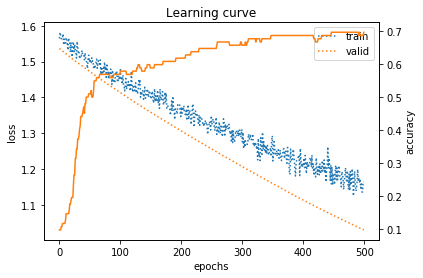

In [8]:
learning_curve(simple_model)

Text(0,0.5,'principal component 2')

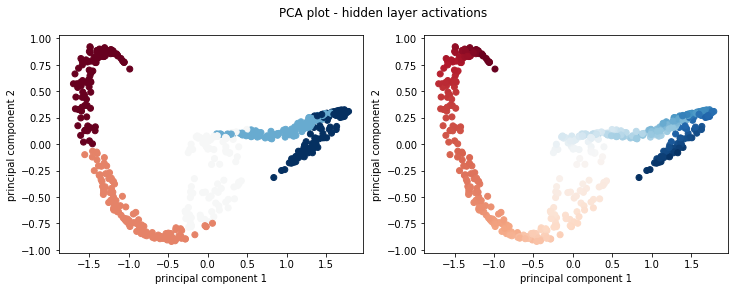

In [9]:
ksi = simple_model.transform(X, name='hidden1')
y_pred = simple_model.predict(X)
ksi2d = PCA(n_components=2).fit_transform(ksi)
plt.figure(figsize=(12,4))
plt.suptitle('PCA plot - hidden layer activations')
plt.subplot(1,2,1)
plt.scatter(*ksi2d.T, c=y)
plt.xlabel('principal component 1')
plt.ylabel('principal component 2')
plt.subplot(1,2,2)
plt.scatter(*ksi2d.T, c=y_orig)
plt.xlabel('principal component 1')
plt.ylabel('principal component 2')

## Training ProtoRegNet
Here we train prototype based version of LDMNet based on the same MLP as before. Same early stopping heuristics apply.

In [10]:
torch.cuda.manual_seed(random_state)

max_epochs = 300

The network trains for `max_epochs`={{max_epochs}}, but can be early stopped if the validation loss does not improve.

In [11]:
module = MLP(X.shape[1], 8, N, drop_proba=0)
model = ProtoRegNet(
    module=module,
    layer_name='hidden1',
    max_epochs=max_epochs,
    batch_size=500,
    lr=0.009,
    n_proto=4, reg=0.25,
    device='cuda',
    verbose=1,
    callbacks=[EarlyStopping(10, 'valid_loss'),
               NaNStopping(), 
               SaveWeights(every_n_epochs=5),
               SaveProtoRegNetVars(every_n_epochs=5)]
)

### Hyper parameters - random search
We choose to adjust the learning rate `lr`, the ADMM mutiplier `mu` and the regularization parameter `lambda_bar` ($\tilde{\lambda}$ in the paper). 20% of training is held out as validation data to evaluate each parameter set.

In [12]:
n_hparams = 5

params = {
'lr': uniform(1e-4, 1e-2),
'reg': reciprocal(1e-3, 2.0),
#'n_proto': randint(2, 20)
}

search = RandomizedSearchCV(
    model, n_iter=n_hparams, n_jobs=1,
    cv=StratifiedShuffleSplit(1, test_size=0.2, random_state=random_state),
    refit=True, random_state=random_state,
    param_distributions=params, verbose=1)

We search for `n_hparams`={{n_hparams}} sets of hyper-parameters.

In [13]:
import os
DIR = 'ProtoRegNetScurve/%d_hparams_%d_max_epochs/' % (n_hparams, max_epochs)
FILE = 'save.pkl'
os.makedirs(DIR, exist_ok=True)
fname = os.path.join(DIR, FILE)
if not os.path.exists(fname) or 1:
    search.fit(X,y)
    pd.to_pickle({'search': search}, fname)
else:
    saved = pd.read_pickle(fname)
    search = saved['search']
model = search.best_estimator_

Fitting 1 folds for each of 5 candidates, totalling 5 fits
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.7040       0.1951        1.7234  0.0083
      2        1.7022       0.1951        1.7214  0.0073
      3        1.7005       0.1951        1.7195  0.0065
      4        1.6987       0.1951        1.7176  0.0083
      5        1.6969       0.1951        1.7157  0.0075
      6        1.6952       0.1951        1.7138  0.0111
      7        1.6935       0.1951        1.7119  0.0075
      8        1.6917       0.1951        1.7100  0.0076
      9        1.6900       0.1951        1.7081  0.0067
     10        1.6883       0.1951        1.7062  0.0064
     11        1.6866       0.1951        1.7044  0.0073
     12        1.6849       0.1951        1.7025  0.0073
     13        1.6832       0.1951        1.7007  0.0065
     14        1.6816       0.1951        1.6988  0.0082
     15        1.6799       0

    108        1.5490       0.1951        1.5563  0.0064
    109        1.5478       0.1951        1.5550  0.0080
    110        1.5466       0.1951        1.5537  0.0065
    111        1.5453       0.1951        1.5524  0.0063
    112        1.5441       0.1951        1.5511  0.0075
    113        1.5429       0.1951        1.5498  0.0065
    114        1.5417       0.1951        1.5486  0.0068
    115        1.5405       0.1951        1.5473  0.0077
    116        1.5393       0.1951        1.5460  0.0070
    117        1.5380       0.1951        1.5447  0.0090
    118        1.5368       0.1951        1.5435  0.0061
    119        1.5356       0.1951        1.5422  0.0059
    120        1.5344       0.1951        1.5409  0.0062
    121        1.5332       0.1951        1.5397  0.0061
    122        1.5320       0.1951        1.5384  0.0063
    123        1.5308       0.1951        1.5372  0.0107
    124        1.5297       0.1951        1.5359  0.0071
    125        1.5285       0.1

    215        1.4279       0.4634        1.4306  0.0079
    216        1.4269       0.4634        1.4295  0.0071
    217        1.4258       0.4634        1.4284  0.0063
    218        1.4248       0.4634        1.4273  0.0080
    219        1.4237       0.4634        1.4263  0.0064
    220        1.4226       0.4634        1.4252  0.0067
    221        1.4216       0.4634        1.4241  0.0065
    222        1.4205       0.4634        1.4230  0.0079
    223        1.4195       0.4634        1.4220  0.0072
    224        1.4184       0.4634        1.4209  0.0059
    225        1.4174       0.4634        1.4198  0.0062
    226        1.4163       0.4634        1.4187  0.0064
    227        1.4153       0.4756        1.4177  0.0063
    228        1.4142       0.4756        1.4166  0.0079
    229        1.4132       0.4756        1.4155  0.0069
    230        1.4121       0.4756        1.4145  0.0068
    231        1.4111       0.4756        1.4134  0.0076
    232        1.4100       0.4

     22        1.6591       0.1951        1.6681  0.0065
     23        1.6574       0.1951        1.6662  0.0075
     24        1.6556       0.1951        1.6643  0.0067
     25        1.6539       0.1951        1.6624  0.0062
     26        1.6522       0.1951        1.6606  0.0065
     27        1.6505       0.1951        1.6587  0.0077
     28        1.6488       0.1951        1.6569  0.0088
     29        1.6471       0.1951        1.6550  0.0071
     30        1.6454       0.1951        1.6532  0.0075
     31        1.6437       0.1951        1.6514  0.0081
     32        1.6420       0.1951        1.6495  0.0073
     33        1.6404       0.1951        1.6477  0.0071
     34        1.6387       0.1951        1.6459  0.0069
     35        1.6371       0.1951        1.6442  0.0070
     36        1.6354       0.1951        1.6424  0.0075
     37        1.6338       0.1951        1.6406  0.0077
     38        1.6321       0.1951        1.6388  0.0080
     39        1.6305       0.1

    131        1.5003       0.2317        1.4987  0.0060
    132        1.4990       0.2439        1.4974  0.0073
    133        1.4977       0.2439        1.4960  0.0060
    134        1.4965       0.2561        1.4947  0.0063
    135        1.4952       0.2561        1.4934  0.0069
    136        1.4939       0.2805        1.4921  0.0066
    137        1.4927       0.2805        1.4908  0.0070
    138        1.4914       0.2805        1.4894  0.0068
    139        1.4901       0.2927        1.4881  0.0079
    140        1.4889       0.2927        1.4868  0.0078
    141        1.4876       0.2927        1.4855  0.0062
    142        1.4864       0.2927        1.4842  0.0068
    143        1.4851       0.2927        1.4829  0.0060
    144        1.4839       0.2927        1.4816  0.0060
    145        1.4826       0.2927        1.4803  0.0062
    146        1.4814       0.3049        1.4790  0.0069
    147        1.4801       0.3049        1.4777  0.0061
    148        1.4789       0.3

    239        1.3710       0.5000        1.3660  0.0058
    240        1.3699       0.5000        1.3648  0.0060
    241        1.3687       0.5000        1.3637  0.0058
    242        1.3676       0.5000        1.3625  0.0059
    243        1.3664       0.5000        1.3614  0.0058
    244        1.3653       0.5000        1.3602  0.0060
    245        1.3642       0.5000        1.3591  0.0075
    246        1.3630       0.5000        1.3580  0.0065
    247        1.3619       0.5000        1.3568  0.0060
    248        1.3608       0.5000        1.3557  0.0066
    249        1.3596       0.5000        1.3545  0.0068
    250        1.3585       0.5000        1.3534  0.0067
    251        1.3574       0.5000        1.3523  0.0079
    252        1.3563       0.5000        1.3511  0.0063
    253        1.3551       0.5000        1.3500  0.0067
    254        1.3540       0.5000        1.3489  0.0062
    255        1.3529       0.5000        1.3478  0.0061
    256        1.3518       0.5

     47        1.6421       0.1951        1.6528  0.0058
     48        1.6409       0.1951        1.6515  0.0062
     49        1.6398       0.1951        1.6503  0.0076
     50        1.6386       0.1951        1.6490  0.0063
     51        1.6374       0.1951        1.6477  0.0075
     52        1.6363       0.1951        1.6465  0.0066
     53        1.6351       0.1951        1.6452  0.0065
     54        1.6340       0.1951        1.6440  0.0072
     55        1.6328       0.1951        1.6427  0.0065
     56        1.6317       0.1951        1.6415  0.0065
     57        1.6305       0.1951        1.6402  0.0065
     58        1.6294       0.1951        1.6390  0.0067
     59        1.6282       0.1951        1.6378  0.0059
     60        1.6271       0.1951        1.6366  0.0059
     61        1.6260       0.1951        1.6353  0.0063
     62        1.6249       0.1951        1.6341  0.0076
     63        1.6237       0.1951        1.6329  0.0060
     64        1.6226       0.1

    157        1.5284       0.1951        1.5314  0.0060
    158        1.5275       0.1951        1.5304  0.0067
    159        1.5266       0.1951        1.5294  0.0072
    160        1.5256       0.1951        1.5284  0.0063
    161        1.5247       0.1951        1.5275  0.0062
    162        1.5238       0.1951        1.5265  0.0067
    163        1.5229       0.1951        1.5255  0.0059
    164        1.5219       0.1951        1.5245  0.0064
    165        1.5210       0.1951        1.5236  0.0062
    166        1.5201       0.1951        1.5226  0.0057
    167        1.5192       0.1951        1.5217  0.0060
    168        1.5183       0.1951        1.5207  0.0074
    169        1.5173       0.1951        1.5197  0.0058
    170        1.5164       0.1951        1.5188  0.0056
    171        1.5155       0.1951        1.5178  0.0071
    172        1.5146       0.1951        1.5169  0.0067
    173        1.5137       0.1951        1.5159  0.0064
    174        1.5128       0.1

    264        1.4345       0.4634        1.4337  0.0063
    265        1.4336       0.4512        1.4329  0.0060
    266        1.4328       0.4512        1.4320  0.0061
    267        1.4320       0.4512        1.4312  0.0062
    268        1.4311       0.4512        1.4303  0.0062
    269        1.4303       0.4512        1.4295  0.0063
    270        1.4295       0.4512        1.4286  0.0063
    271        1.4286       0.4512        1.4277  0.0063
    272        1.4278       0.4512        1.4269  0.0073
    273        1.4270       0.4512        1.4260  0.0097
    274        1.4261       0.4512        1.4252  0.0062
    275        1.4253       0.4512        1.4243  0.0071
    276        1.4245       0.4512        1.4235  0.0095
    277        1.4236       0.4634        1.4226  0.0060
    278        1.4228       0.4634        1.4218  0.0066
    279        1.4220       0.4634        1.4210  0.0088
    280        1.4211       0.4634        1.4201  0.0062
    281        1.4203       0.4

     72        1.6379       0.1951        1.6750  0.0062
     73        1.6368       0.1951        1.6738  0.0061
     74        1.6357       0.1951        1.6726  0.0062
     75        1.6345       0.1951        1.6714  0.0059
     76        1.6334       0.1951        1.6702  0.0058
     77        1.6323       0.1951        1.6690  0.0058
     78        1.6312       0.1951        1.6678  0.0061
     79        1.6301       0.1951        1.6666  0.0059
     80        1.6290       0.1951        1.6654  0.0062
     81        1.6279       0.1951        1.6643  0.0073
     82        1.6268       0.1951        1.6631  0.0068
     83        1.6257       0.1951        1.6619  0.0066
     84        1.6246       0.1951        1.6607  0.0076
     85        1.6236       0.1951        1.6596  0.0060
     86        1.6225       0.1951        1.6584  0.0064
     87        1.6214       0.1951        1.6572  0.0068
     88        1.6203       0.1951        1.6561  0.0057
     89        1.6192       0.1

    181        1.5298       0.2317        1.5603  0.0059
    182        1.5290       0.2439        1.5594  0.0061
    183        1.5281       0.2439        1.5585  0.0059
    184        1.5272       0.2439        1.5575  0.0061
    185        1.5263       0.2561        1.5566  0.0060
    186        1.5254       0.2561        1.5557  0.0079
    187        1.5245       0.2805        1.5548  0.0069
    188        1.5236       0.2805        1.5538  0.0068
    189        1.5227       0.2805        1.5529  0.0064
    190        1.5219       0.2805        1.5520  0.0066
    191        1.5210       0.2805        1.5511  0.0063
    192        1.5201       0.2927        1.5502  0.0064
    193        1.5192       0.2927        1.5493  0.0063
    194        1.5183       0.2927        1.5484  0.0061
    195        1.5174       0.2927        1.5475  0.0059
    196        1.5166       0.2927        1.5465  0.0061
    197        1.5157       0.2927        1.5456  0.0062
    198        1.5148       0.2

    289        1.4389       0.4756        1.4675  0.0070
    290        1.4381       0.4756        1.4667  0.0060
    291        1.4373       0.4756        1.4659  0.0057
    292        1.4365       0.4756        1.4651  0.0059
    293        1.4357       0.4756        1.4643  0.0062
    294        1.4349       0.4756        1.4635  0.0063
    295        1.4341       0.4756        1.4627  0.0062
    296        1.4333       0.4756        1.4619  0.0063
    297        1.4325       0.4756        1.4611  0.0063
    298        1.4317       0.4756        1.4603  0.0063
    299        1.4310       0.4756        1.4595  0.0063
    300        1.4302       0.4756        1.4587  0.0067
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.6961       0.1951        1.7056  0.0059
      2        1.6931       0.1951        1.7022  0.0062
      3        1.6900       0.1951        1.6989  0.0078
      4        1.6870       0.1

     96        1.4722       0.3415        1.4669  0.0064
     97        1.4702       0.3537        1.4649  0.0062
     98        1.4682       0.3659        1.4628  0.0071
     99        1.4663       0.3902        1.4608  0.0059
    100        1.4643       0.3902        1.4588  0.0062
    101        1.4624       0.3902        1.4568  0.0099
    102        1.4604       0.4024        1.4547  0.0067
    103        1.4585       0.4146        1.4527  0.0068
    104        1.4565       0.4146        1.4507  0.0067
    105        1.4546       0.4146        1.4487  0.0066
    106        1.4526       0.4146        1.4467  0.0063
    107        1.4507       0.4390        1.4447  0.0063
    108        1.4488       0.4512        1.4427  0.0064
    109        1.4469       0.4512        1.4407  0.0065
    110        1.4449       0.4512        1.4387  0.0064
    111        1.4430       0.4512        1.4368  0.0065
    112        1.4411       0.4512        1.4348  0.0065
    113        1.4392       0.4

    204        1.2754       0.5244        1.2683  0.0059
    205        1.2737       0.5244        1.2666  0.0057
    206        1.2720       0.5244        1.2650  0.0056
    207        1.2703       0.5244        1.2633  0.0056
    208        1.2686       0.5244        1.2617  0.0060
    209        1.2669       0.5244        1.2600  0.0057
    210        1.2653       0.5244        1.2584  0.0059
    211        1.2636       0.5244        1.2567  0.0057
    212        1.2619       0.5244        1.2551  0.0060
    213        1.2602       0.5244        1.2535  0.0057
    214        1.2586       0.5244        1.2518  0.0056
    215        1.2569       0.5244        1.2502  0.0059
    216        1.2552       0.5244        1.2486  0.0060
    217        1.2536       0.5244        1.2470  0.0062
    218        1.2519       0.5244        1.2453  0.0063
    219        1.2503       0.5244        1.2437  0.0062
    220        1.2486       0.5244        1.2421  0.0064
    221        1.2470       0.5

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   20.4s finished


     11        1.6750       0.1961        1.6679  0.0076
     12        1.6721       0.1961        1.6650  0.0089
     13        1.6692       0.1961        1.6622  0.0080
     14        1.6663       0.1961        1.6593  0.0103
     15        1.6635       0.1961        1.6565  0.0085
     16        1.6607       0.1961        1.6537  0.0095
     17        1.6579       0.1961        1.6510  0.0084
     18        1.6551       0.1961        1.6482  0.0090
     19        1.6524       0.1961        1.6455  0.0079
     20        1.6497       0.1961        1.6428  0.0081
     21        1.6470       0.1961        1.6401  0.0079
     22        1.6443       0.1961        1.6375  0.0088
     23        1.6416       0.1961        1.6348  0.0099
     24        1.6390       0.1961        1.6322  0.0085
     25        1.6363       0.1961        1.6296  0.0087
     26        1.6337       0.1961        1.6270  0.0082
     27        1.6311       0.1961        1.6244  0.0085
     28        1.6285       0.1

    118        1.4368       0.4412        1.4311  0.0078
    119        1.4349       0.4412        1.4293  0.0087
    120        1.4331       0.4412        1.4274  0.0080
    121        1.4312       0.4412        1.4255  0.0127
    122        1.4293       0.4412        1.4237  0.0085
    123        1.4275       0.4510        1.4218  0.0083
    124        1.4256       0.4510        1.4199  0.0086
    125        1.4238       0.4608        1.4181  0.0086
    126        1.4219       0.4608        1.4162  0.0090
    127        1.4200       0.4706        1.4144  0.0096
    128        1.4182       0.4706        1.4125  0.0086
    129        1.4164       0.4706        1.4107  0.0084
    130        1.4145       0.4902        1.4089  0.0086
    131        1.4127       0.5000        1.4070  0.0092
    132        1.4108       0.5000        1.4052  0.0088
    133        1.4090       0.5098        1.4034  0.0080
    134        1.4072       0.5098        1.4015  0.0085
    135        1.4053       0.5

    227        1.2476       0.5392        1.2423  0.0076
    228        1.2460       0.5392        1.2407  0.0087
    229        1.2444       0.5392        1.2391  0.0076
    230        1.2428       0.5392        1.2376  0.0091
    231        1.2412       0.5392        1.2360  0.0083
    232        1.2396       0.5392        1.2344  0.0081
    233        1.2380       0.5392        1.2328  0.0092
    234        1.2364       0.5392        1.2313  0.0093
    235        1.2349       0.5392        1.2297  0.0082
    236        1.2333       0.5392        1.2281  0.0077
    237        1.2317       0.5392        1.2266  0.0098
    238        1.2302       0.5392        1.2250  0.0089
    239        1.2286       0.5392        1.2234  0.0074
    240        1.2270       0.5392        1.2219  0.0078
    241        1.2255       0.5392        1.2203  0.0090
    242        1.2239       0.5392        1.2188  0.0073
    243        1.2223       0.5392        1.2172  0.0079
    244        1.2208       0.5

#### Hyper-parameters - best set
The model is retrained over the complete training set using the best parameters found. Here are the parameters and the accuracy over the training set.

In [14]:
model = search.best_estimator_
print("best params", search.best_params_)
print("validation accuracy", model.score(X, y))

best params {'lr': 0.009736627605010293, 'reg': 0.018439619501993142}
validation accuracy 0.618


#### Hyper-parameters - best parameter sets in the hyper-parameter space
Here only the other parameter-sets yielding validation accuracy better than 90%

In [15]:
results = search.cv_results_
results = pd.DataFrame(results)
df=pd.DataFrame(results, columns=['param_' + p for p in params.keys()])

/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [16]:
df

param_lr  param_reg
0  0.00558814   0.229542
1  0.00612763  0.0629036
2  0.00433655   0.135555
3  0.00447587   0.878556
4  0.00973663  0.0184396

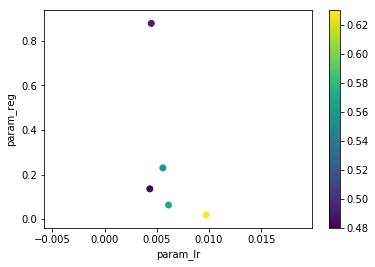

In [17]:
fig = plt.figure()
mask = results.mean_test_score.values > 0
#ax = fig.add_subplot(111, projection='3d')
ax = plt.gca()
p = ax.scatter(*df.values[mask].T, c=results.mean_test_score.values[mask], cmap='viridis')
#set_labels = lambda x, y, z: (ax.set_xlabel(x), ax.set_ylabel(y), ax.set_zlabel(z))
set_labels = lambda x, y: (ax.set_xlabel(x), ax.set_ylabel(y))
set_labels(*df.columns.values)
plt.colorbar(p)


### Observing  training

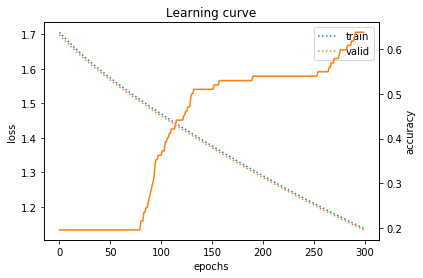

In [18]:
learning_curve(model)

#### PCA plots of feature space ksi
Here we plot 2D - PCA views of the hidden layer activations -- `ksi`-- and of the perturbed coordinate functions `alpha` to which they are regularized, as the iterations proceed.

In [19]:
%run LDMM_plot_utils.py

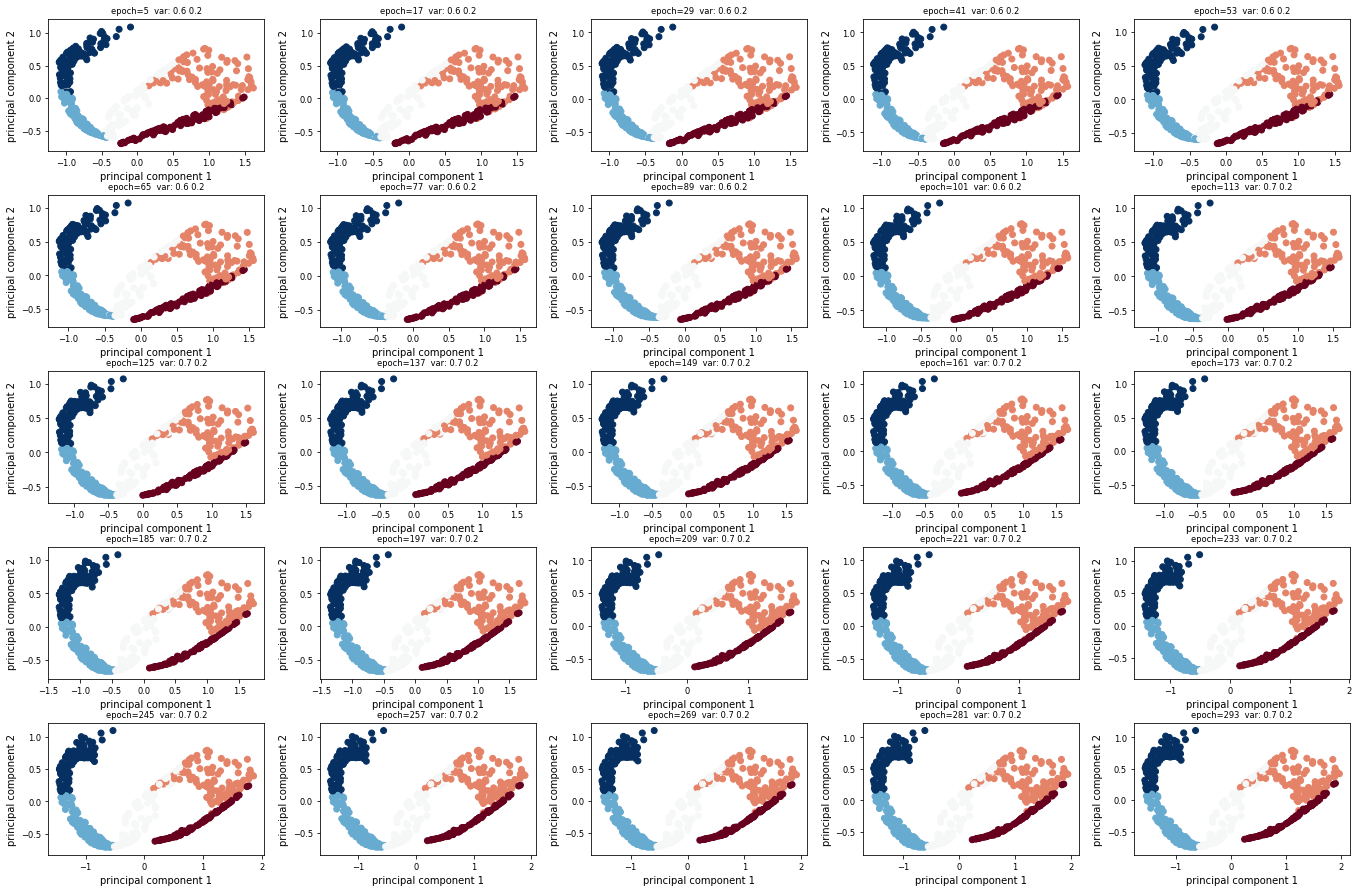

In [20]:
plt.rcParams['image.cmap'] = 'RdBu'
out = plot_over_time(model, 'ksi', every_n=2, y=y)
plt.tight_layout(h_pad=0.1)

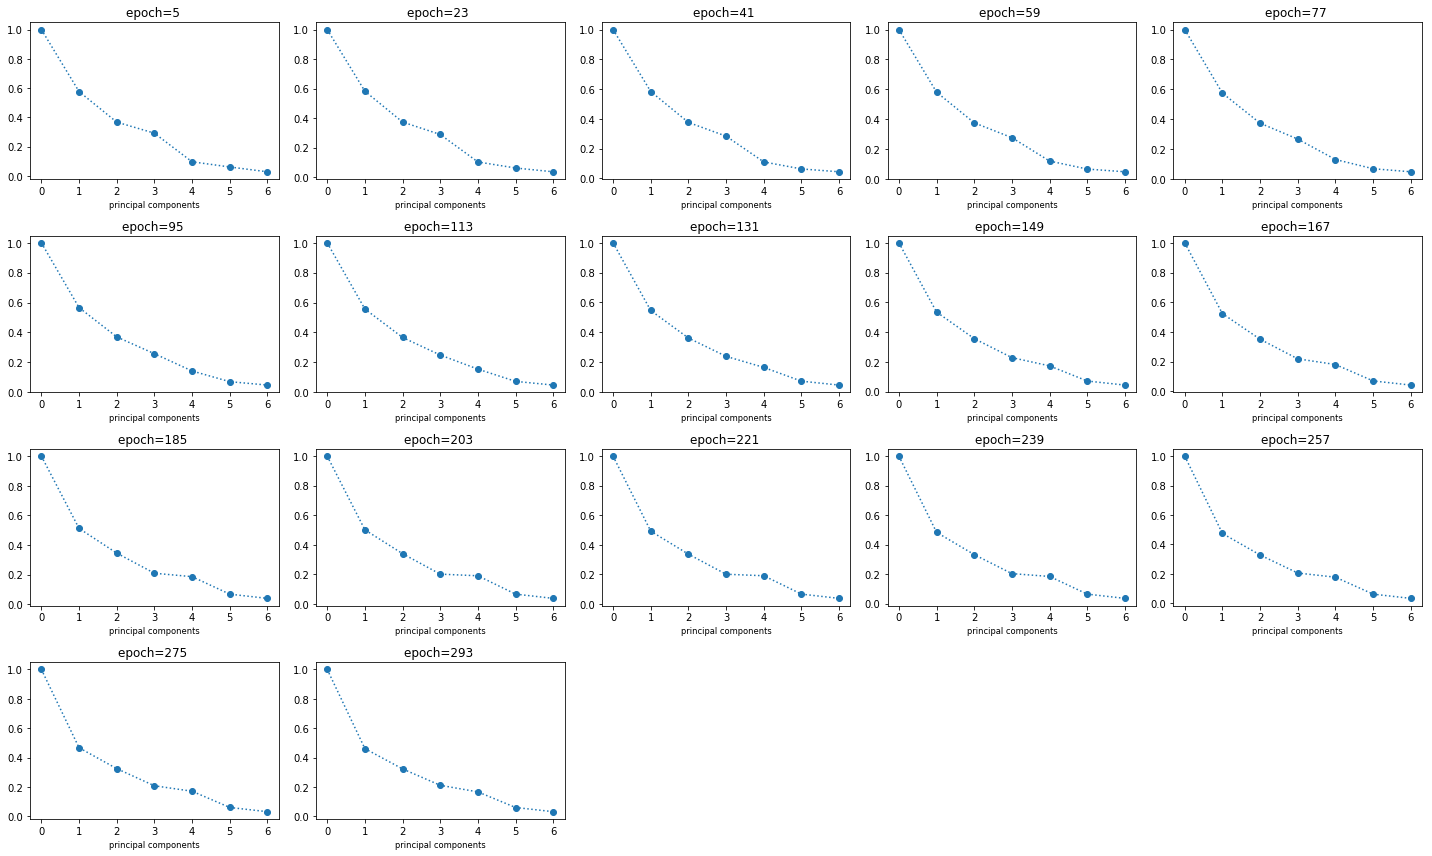

In [21]:
_ = plot_sv_over_time(model, 'ksi')

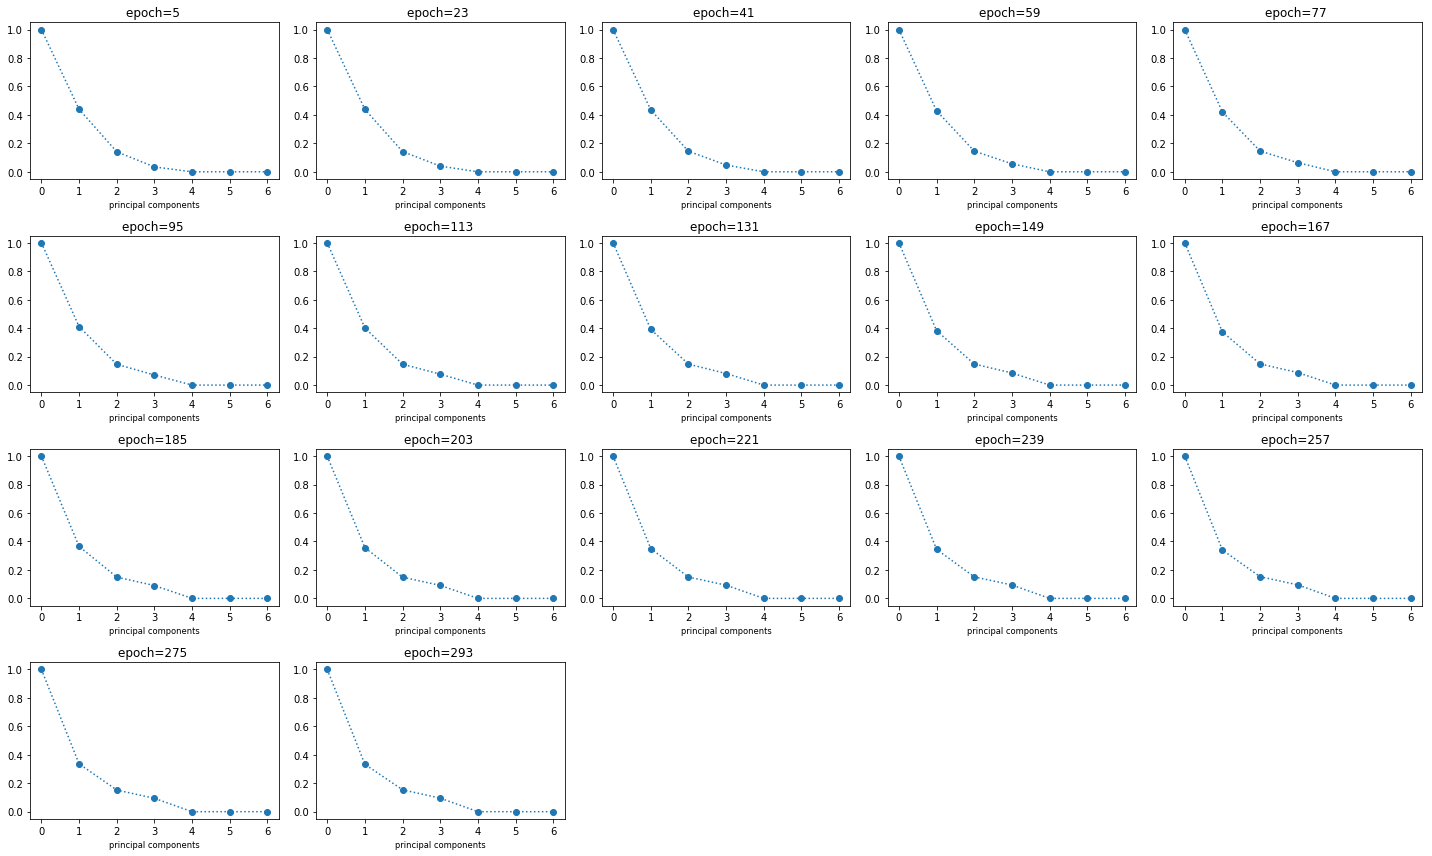

In [22]:
_ = plot_sv_over_time(model, 'alpha')

In this plot, the PCA is calculated at each time step for `alpha` and the same projection is used to plot `ksi`. The idea is to see in a common space how different were `ksi` and `alpha` during the optimization.

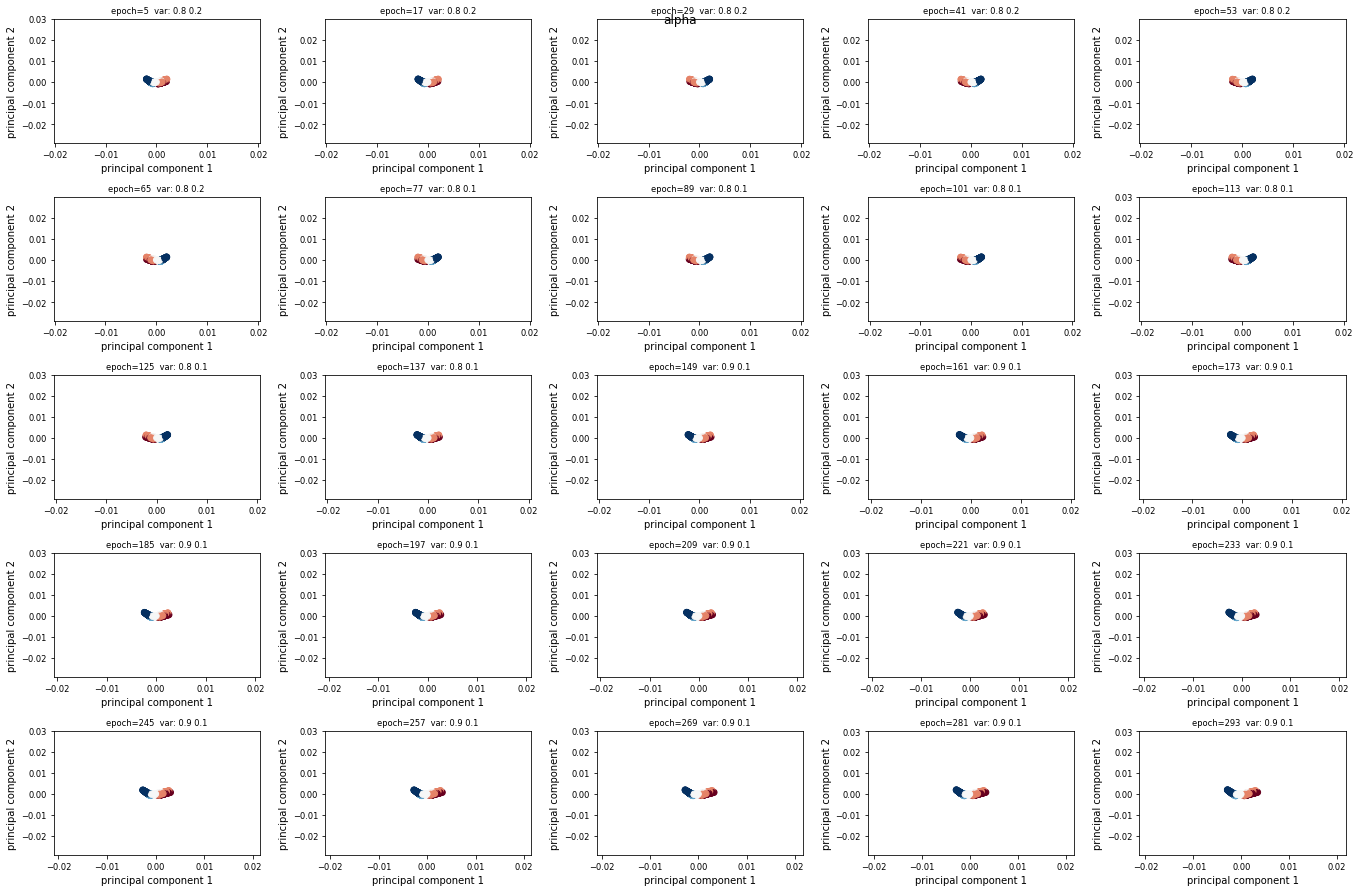

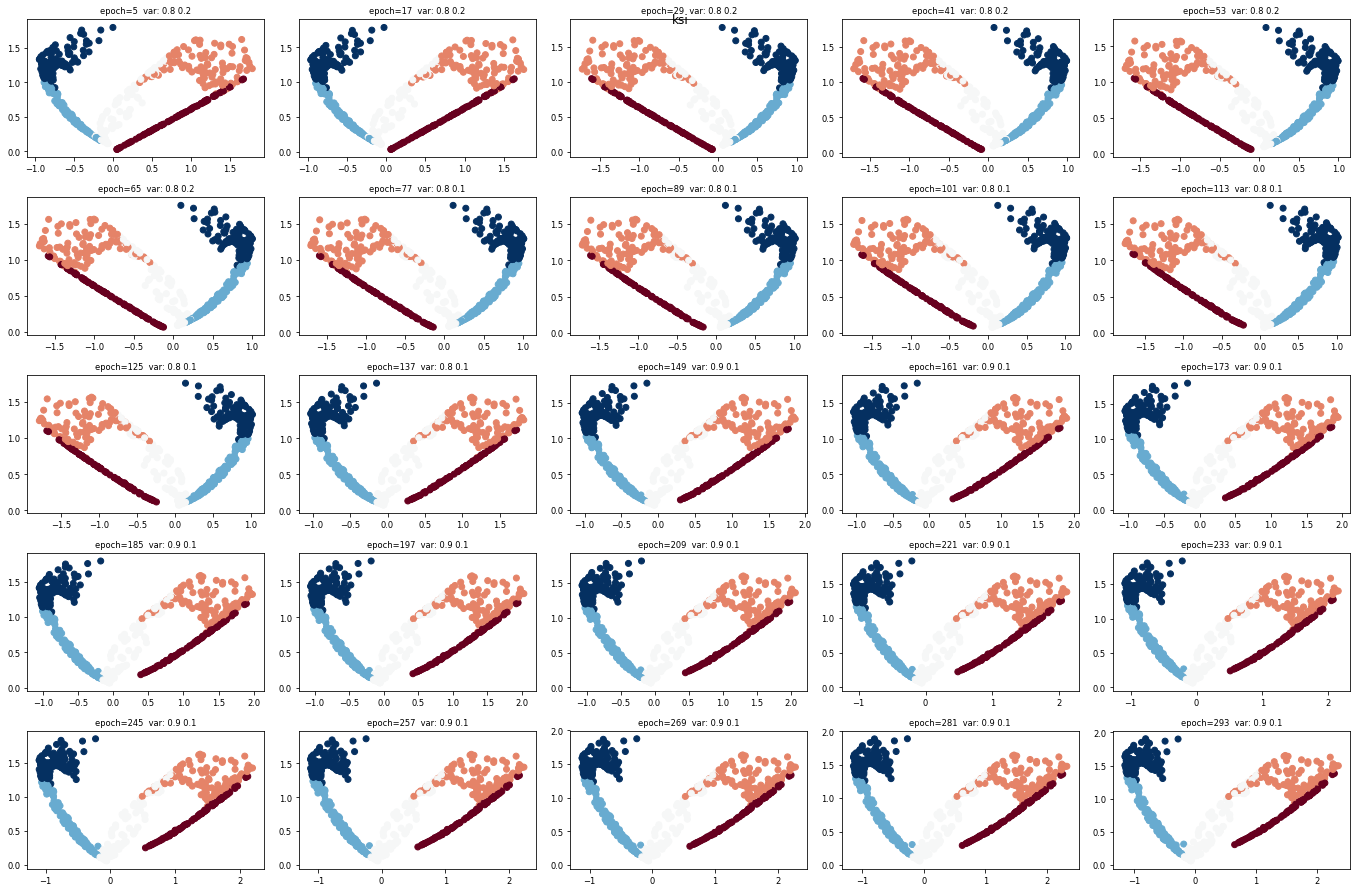

In [23]:
plot_ksi_alpha_time(model, every_n=2, y=y)
#plt.tight_layout(h_pad=0.1)

#### Average values per feature along the iterations
To get a sense of the convergence, here we plot average values per feature (i.e. per neuron of the hidden layer) of : 
- `alpha`
- dual variable `Z`
- activations `ksi`
- weights and bias of the hidden and output layers

We also plot their variations -- delta -- along the iterations. A smothing window is used for delta `alpha` and delta `Z`.
##### Evolution of Z, alpha and ksi

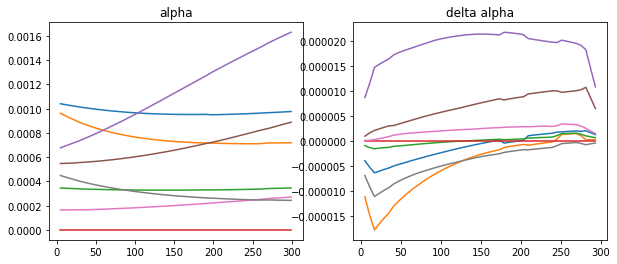

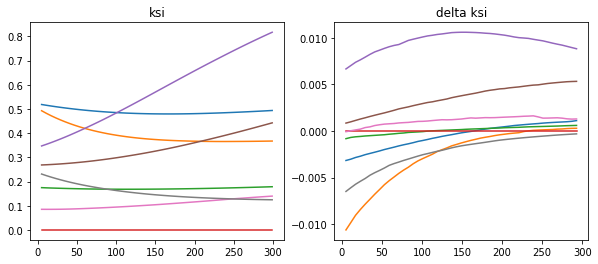

In [24]:
# plot_ldmm_vars(model, 'Z', smooth_delta=5)
plot_ldmm_vars(model, 'alpha', smooth_delta=5)
plot_ldmm_vars(model, 'ksi', smooth_delta=0)

##### Evolution of weights and bias 

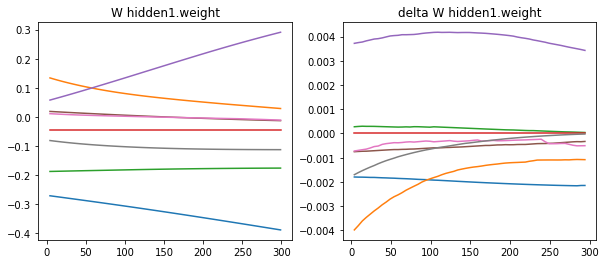

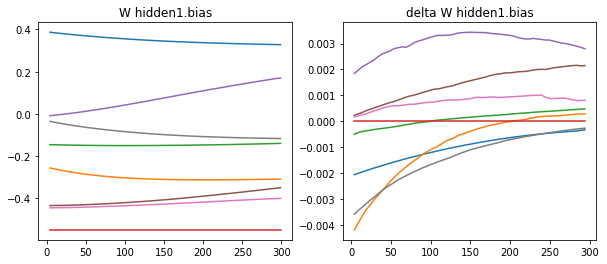

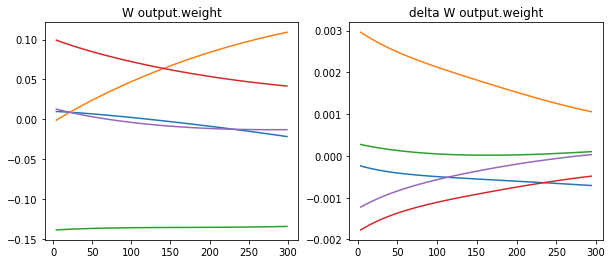

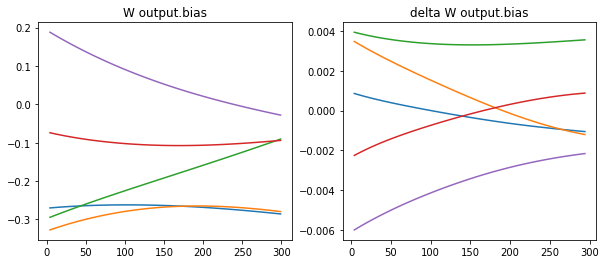

In [25]:
plot_net_weights(model, 'hidden1', smooth_delta=0)
plot_net_weights(model, 'output', smooth_delta=0)